In [2]:
import earthaccess
import datatree
import s3fs
import xarray as xr
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd

In [2]:
# Authenticate to EDL
auth = earthaccess.login(strategy="interactive", persist=False)


Enter your Earthdata Login username:  alexdevseed
Enter your Earthdata password:  ········


You're now authenticated with NASA Earthdata Login
Using token with expiration date: 10/07/2023
Using user provided credentials for EDL


In [5]:
# Setup s3 keys
s3 = earthaccess.get_s3fs_session(daac="NSIDC", provider=auth)
s3url_atl03 = 's3://nsidc-cumulus-prod-protected/ATLAS/ATL03/006/2019/11/30/ATL03_20191130112041_09860505_006_01.h5'


In [3]:
s3 = s3fs.S3FileSystem(anon=False)
# Alternate from hackweek bucket
s3url_atl03 = 's3://nasa-cryo-scratch/h5cloud/original/ATL03_20190219140808_08110212_006_02.h5'
# Repacked
#s3url_atl03 = 's3://nasa-cryo-scratch/h5cloud/h5repack/ATL03_20190219140808_08110212_006_02_repacked.h5'

In [ ]:
%%time
ds = xr.open_dataset(s3.open(s3url_atl03, 'rb'))
ds


In [4]:
%%time
ds_track = xr.open_dataset(s3.open(s3url_atl03, 'rb'), group='/gt2l/heights')
ds_track

CPU times: user 20.1 s, sys: 5.44 s, total: 25.5 s
Wall time: 1min 22s


<xarray.Dataset>
Dimensions:         (delta_time: 61723873, ds_surf_type: 5)
Coordinates:
  * delta_time      (delta_time) datetime64[ns] 2019-02-19T14:08:08.538445348...
    lat_ph          (delta_time) float64 ...
    lon_ph          (delta_time) float64 ...
Dimensions without coordinates: ds_surf_type
Data variables:
    dist_ph_across  (delta_time) float32 ...
    dist_ph_along   (delta_time) float32 ...
    h_ph            (delta_time) float32 ...
    pce_mframe_cnt  (delta_time) uint32 ...
    ph_id_channel   (delta_time) uint8 ...
    ph_id_count     (delta_time) uint8 ...
    ph_id_pulse     (delta_time) uint8 ...
    quality_ph      (delta_time) int8 ...
    signal_conf_ph  (delta_time, ds_surf_type) int8 ...
    weight_ph       (delta_time) uint8 ...
Attributes:
    Description:  Contains arrays of the parameters for each received photon.
    data_rate:    Data are stored at the photon detection rate.

In [ ]:
df = ds_track.to_dataframe().reset_index()

In [ ]:
# try to free up memory
del ds_track

In [16]:
#pivot on ds_surf_type to wider format
keep = [col for col in df.columns.values.tolist() if col not in ["ds_surf_type", "signal_conf_ph"]]

In [20]:
df_flat = df.pivot(index=keep, columns='ds_surf_type', values='signal_conf_ph').reset_index()

In [19]:
df_flat

ds_surf_type,delta_time,dist_ph_across,dist_ph_along,h_ph,lat_ph,lon_ph,pce_mframe_cnt,ph_id_channel,ph_id_count,ph_id_pulse,quality_ph,weight_ph,0,1,2,3,4
0,2019-11-30 11:20:41.001794496,49.707001,0.357462,2163.680176,80.000033,-40.324937,20658495,38,1,122,0,124,4,-1,-1,4,4
1,2019-11-30 11:20:41.001894496,49.707138,1.060720,2163.784668,80.000026,-40.324945,20658495,39,1,123,0,125,4,-1,-1,4,4
2,2019-11-30 11:20:41.001894496,49.707169,1.060982,2163.681641,80.000026,-40.324945,20658495,97,1,123,0,124,4,-1,-1,4,4
3,2019-11-30 11:20:41.001994504,49.707279,1.764051,2163.887939,80.000020,-40.324952,20658495,37,1,124,0,125,4,-1,-1,4,4
4,2019-11-30 11:20:41.002194504,49.707699,3.171636,2163.694824,80.000008,-40.324968,20658495,40,1,126,0,186,4,-1,-1,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2864196,2019-11-30 11:26:06.063202376,33.518913,10.045416,36.621101,59.500962,-49.672708,20674748,39,1,136,0,0,-1,0,0,-1,-1
2864197,2019-11-30 11:26:06.065002400,33.465836,3.446925,-184.907959,59.500842,-49.672733,20674748,98,1,154,0,0,-1,0,0,-1,-1
2864198,2019-11-30 11:26:06.065302368,33.595997,4.628528,186.278503,59.500832,-49.672732,20674748,99,1,157,0,0,-1,0,0,-1,-1
2864199,2019-11-30 11:26:06.066902384,33.648296,15.784384,287.965515,59.500732,-49.672752,20674748,38,1,173,0,0,-1,0,0,-1,-1


In [ ]:
# memory cleanup
del df

In [27]:
new_cols = {col:f'surf_type_sig_conf-{col}' for col in df_flat.columns[12:17]}
df_flat.rename(columns=new_cols, inplace=True)

In [31]:
# make a geodataframe out of it
gdf = gpd.GeoDataFrame(df_flat, geometry=gpd.points_from_xy(df_flat.lon_ph, df_flat.lat_ph))

In [35]:
gdf

ds_surf_type,delta_time,dist_ph_across,dist_ph_along,h_ph,lat_ph,lon_ph,pce_mframe_cnt,ph_id_channel,ph_id_count,ph_id_pulse,quality_ph,weight_ph,surf_type_sig_conf-0,surf_type_sig_conf-1,surf_type_sig_conf-2,surf_type_sig_conf-3,surf_type_sig_conf-4,geometry
0,2019-11-30 11:20:41.001794496,49.707001,0.357462,2163.680176,80.000033,-40.324937,20658495,38,1,122,0,124,4,-1,-1,4,4,POINT (-40.32494 80.00003)
1,2019-11-30 11:20:41.001894496,49.707138,1.060720,2163.784668,80.000026,-40.324945,20658495,39,1,123,0,125,4,-1,-1,4,4,POINT (-40.32494 80.00003)
2,2019-11-30 11:20:41.001894496,49.707169,1.060982,2163.681641,80.000026,-40.324945,20658495,97,1,123,0,124,4,-1,-1,4,4,POINT (-40.32494 80.00003)
3,2019-11-30 11:20:41.001994504,49.707279,1.764051,2163.887939,80.000020,-40.324952,20658495,37,1,124,0,125,4,-1,-1,4,4,POINT (-40.32495 80.00002)
4,2019-11-30 11:20:41.002194504,49.707699,3.171636,2163.694824,80.000008,-40.324968,20658495,40,1,126,0,186,4,-1,-1,4,4,POINT (-40.32497 80.00001)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2864196,2019-11-30 11:26:06.063202376,33.518913,10.045416,36.621101,59.500962,-49.672708,20674748,39,1,136,0,0,-1,0,0,-1,-1,POINT (-49.67271 59.50096)
2864197,2019-11-30 11:26:06.065002400,33.465836,3.446925,-184.907959,59.500842,-49.672733,20674748,98,1,154,0,0,-1,0,0,-1,-1,POINT (-49.67273 59.50084)
2864198,2019-11-30 11:26:06.065302368,33.595997,4.628528,186.278503,59.500832,-49.672732,20674748,99,1,157,0,0,-1,0,0,-1,-1,POINT (-49.67273 59.50083)
2864199,2019-11-30 11:26:06.066902384,33.648296,15.784384,287.965515,59.500732,-49.672752,20674748,38,1,173,0,0,-1,0,0,-1,-1,POINT (-49.67275 59.50073)


In [37]:
# drop columns that aren't needed
gdf.drop(columns=['lat_ph','lon_ph'], inplace=True)

In [38]:
gdf

ds_surf_type,delta_time,dist_ph_across,dist_ph_along,h_ph,pce_mframe_cnt,ph_id_channel,ph_id_count,ph_id_pulse,quality_ph,weight_ph,surf_type_sig_conf-0,surf_type_sig_conf-1,surf_type_sig_conf-2,surf_type_sig_conf-3,surf_type_sig_conf-4,geometry
0,2019-11-30 11:20:41.001794496,49.707001,0.357462,2163.680176,20658495,38,1,122,0,124,4,-1,-1,4,4,POINT (-40.32494 80.00003)
1,2019-11-30 11:20:41.001894496,49.707138,1.060720,2163.784668,20658495,39,1,123,0,125,4,-1,-1,4,4,POINT (-40.32494 80.00003)
2,2019-11-30 11:20:41.001894496,49.707169,1.060982,2163.681641,20658495,97,1,123,0,124,4,-1,-1,4,4,POINT (-40.32494 80.00003)
3,2019-11-30 11:20:41.001994504,49.707279,1.764051,2163.887939,20658495,37,1,124,0,125,4,-1,-1,4,4,POINT (-40.32495 80.00002)
4,2019-11-30 11:20:41.002194504,49.707699,3.171636,2163.694824,20658495,40,1,126,0,186,4,-1,-1,4,4,POINT (-40.32497 80.00001)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2864196,2019-11-30 11:26:06.063202376,33.518913,10.045416,36.621101,20674748,39,1,136,0,0,-1,0,0,-1,-1,POINT (-49.67271 59.50096)
2864197,2019-11-30 11:26:06.065002400,33.465836,3.446925,-184.907959,20674748,98,1,154,0,0,-1,0,0,-1,-1,POINT (-49.67273 59.50084)
2864198,2019-11-30 11:26:06.065302368,33.595997,4.628528,186.278503,20674748,99,1,157,0,0,-1,0,0,-1,-1,POINT (-49.67273 59.50083)
2864199,2019-11-30 11:26:06.066902384,33.648296,15.784384,287.965515,20674748,38,1,173,0,0,-1,0,0,-1,-1,POINT (-49.67275 59.50073)


<AxesSubplot: >

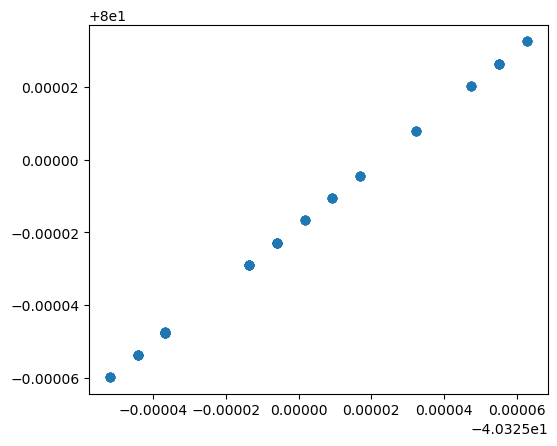

In [26]:
gdf.head(n=100).plot()

In [39]:
gdf.shape

(2864201, 16)

In [41]:
gdf.dtypes

ds_surf_type
delta_time              datetime64[ns]
dist_ph_across                 float64
dist_ph_along                  float64
h_ph                           float64
pce_mframe_cnt                  uint64
ph_id_channel                   uint64
ph_id_count                     uint64
ph_id_pulse                     uint64
quality_ph                       int64
weight_ph                       uint64
surf_type_sig_conf-0              int8
surf_type_sig_conf-1              int8
surf_type_sig_conf-2              int8
surf_type_sig_conf-3              int8
surf_type_sig_conf-4              int8
geometry                      geometry
dtype: object

In [42]:
# save to various formats
# geoparquet
file_out = 'ATL03_20191130112041_09860505_006_01-gt2l_hgt.gpq'
gdf.to_parquet(file_out, index=False, use_deprecated_int96_timestamps=True)